# Preliminary Data Exploration

This is where we'll do our primary data exploration phase to create visualizations that summarize/extract relevant trends, findings, characteristics or features about the dataset. 

We'll also address abnormalities or characteristics about the data that stand out, in addition to some feature engineering.

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

from matplotlib import cm
from scipy.stats import norm, skew

In [2]:
train = pd.read_csv("./train.csv")
train_ID = train["Id"]
#train.drop("Id", axis=1, inplace=True)

test = pd.read_csv("./test.csv")
test_ID = test["Id"] 
#test.drop("Id", axis=1, inplace=True)

# Summary statistics for SalePrice
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

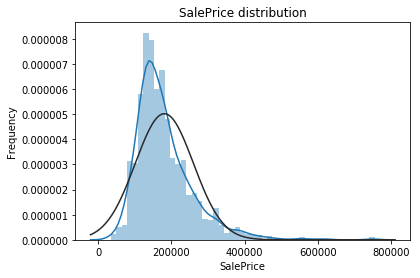

In [3]:
sns.distplot(train.SalePrice,fit=norm)
plt.ylabel("Frequency")
plt.title("SalePrice distribution")
(mu, sigma) = norm.fit(train["SalePrice"])
plt.show()

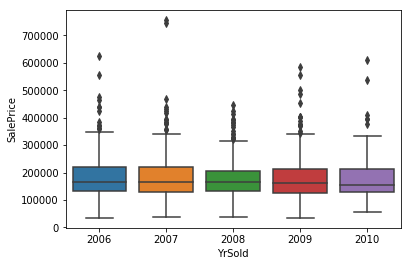

In [5]:
sns.boxplot(train.YrSold,train.SalePrice)
plt.show()

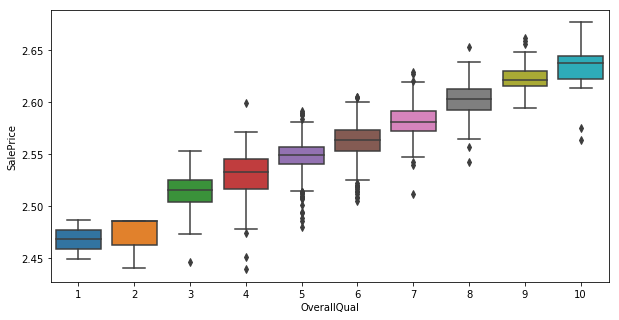

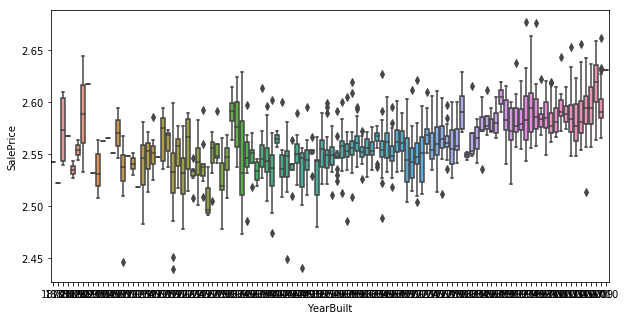

In [86]:
var = 'OverallQual'

def show_boxplot(var):
    data = pd.concat([train['SalePrice'], train[var]], axis=1)
    plt.figure(figsize=(10,5))
    sns.boxplot(x=var, y="SalePrice", data=data)
    plt.show()

show_boxplot(var)

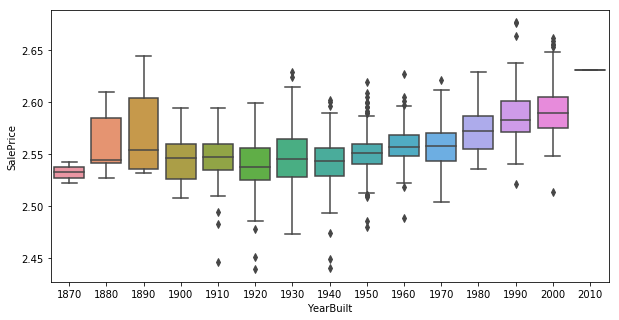

In [88]:
#Group YearBuilt by decade
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], (train[var]//10)*10], axis=1)
plt.figure(figsize=(10,5))
sns.boxplot(x=var, y="SalePrice", data=data)
plt.show()

We assume that neighborhood, year sold and overall condition of the house are important factors that will affect the sale price. We took a look at the boxplots for each variable to see the values at each quartile.

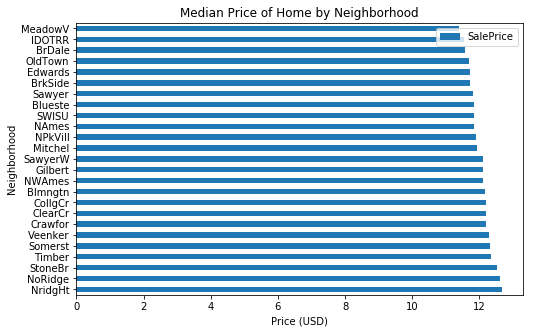

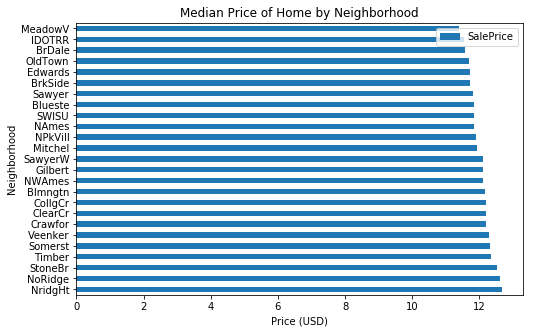

In [45]:
a = pd.DataFrame(train.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending = False))
a.plot.barh(figsize = (8,5))
plt.xlabel('Price (USD)')
plt.title('Median Price of Home by Neighborhood')
plt.show()

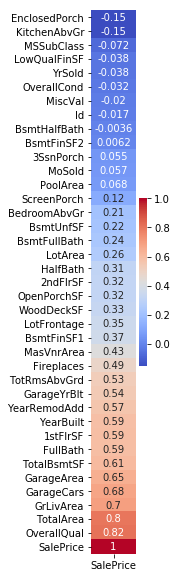

In [83]:
corrmat = train.corr()
indices = corrmat.loc[:,'SalePrice'].copy()
a = pd.DataFrame(indices.sort_values())
plt.figure(figsize=(1,10))
sns.heatmap(a, annot=True, cmap=cm.coolwarm)
plt.show()

In [46]:
# Data transformation + feature engineering 

all_data = pd.concat((train.loc[:,"MSSubClass":"SaleCondition"],
                      test.loc[:,"MSSubClass":"SaleCondition"]))
train["SalePrice"] = np.log1p(train["SalePrice"])
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

train['TotalArea'] = train['TotalBsmtSF'] + train['GarageArea'] + train['GrLivArea']
test['TotalArea'] = test['TotalBsmtSF'] + test['GarageArea'] + test['GrLivArea']


In [47]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())


In [48]:
# j = 0
# for i in (np.corrcoef(train[numeric_feats])[-1]):
#     print (list(train)[j],"   ", i)
#     j+=1

In [49]:
from sklearn.decomposition import PCA
X = all_data[:train.shape[0]]
pca = PCA(n_components=81)
# X is the matrix transposed (n samples on the rows, m features on the columns)
pca.fit(X)

X_new = pca.transform(X)
print (X_new)

[[  7.89064823e+01  -3.66886291e+01   8.70215304e-01 ...,   1.54349544e-01
   -6.74266853e-02  -1.46847537e-02]
 [ -1.30614690e+01   1.74789590e-01  -1.01585869e+01 ...,  -5.81345520e-02
   -2.68019942e-02  -8.24273695e-02]
 [  1.38343535e+02  -2.80016748e+01   9.91517547e-01 ...,   1.21357119e-01
   -1.27457351e-01   5.62240656e-02]
 ..., 
 [ -2.23327665e+02   1.30174055e+01   3.28700367e+01 ...,  -1.81538018e-01
   -4.01220464e-01  -1.07553466e-01]
 [ -2.34562831e+02   4.48584221e+00   1.93569069e+01 ...,  -4.65637062e-02
   -1.72947696e-02  -3.12595194e-01]
 [ -1.97970273e+02   9.06487939e-01  -1.47619913e+01 ...,   5.14939581e-01
   -1.61758443e-01   1.78952091e-02]]


In [50]:

from sklearn.feature_selection import VarianceThreshold
X = all_data[:train.shape[0]]
print (X.shape[1])
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)
print (X.shape[1])

288
288


In [51]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [52]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [53]:
model_ridge = Ridge()

In [54]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

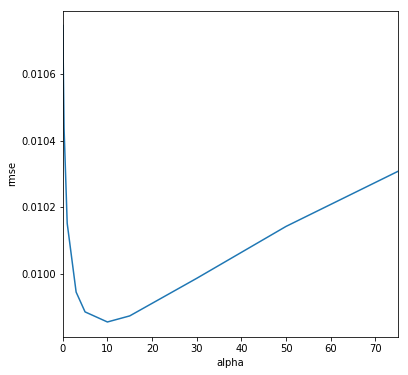

In [55]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = " ")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [56]:
cv_ridge.min()


0.0098561873033253117

In [57]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)


In [58]:
rmse_cv(model_lasso).mean()


0.011227594909962852

In [59]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [60]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 23 variables and eliminated the other 265 variables


In [61]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

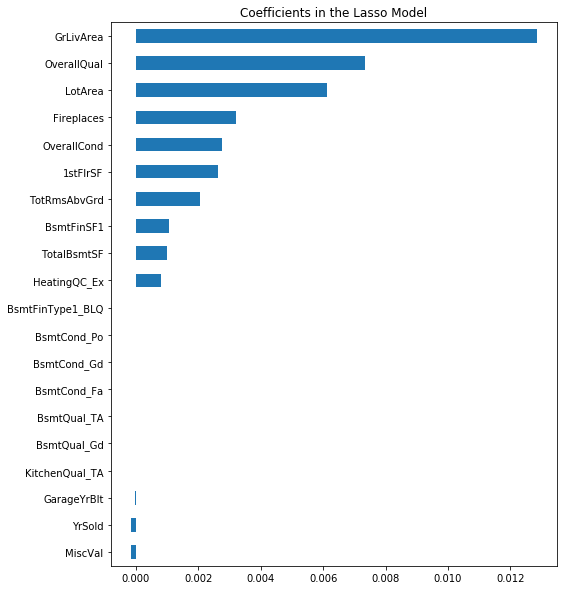

In [62]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [63]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
#preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [64]:
modelridge = RidgeCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
ridge_preds = np.expm1(modelridge.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

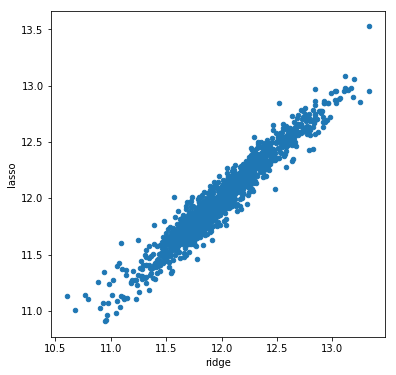

In [65]:

predictions = pd.DataFrame({"ridge":ridge_preds, "lasso":lasso_preds})

predictions.plot(x = "ridge", y = "lasso", kind = "scatter")
plt.show()

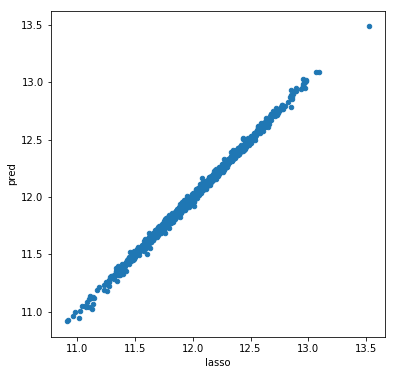

In [66]:
pred = 0.8*lasso_preds + 0.2*ridge_preds
predictions = pd.DataFrame({"lasso":lasso_preds,"pred":pred})
predictions.plot( x = "lasso", y = "pred",kind = "scatter")
plt.show() 

In [67]:
print (test.Id,pred)
output = pd.DataFrame({"id":test.Id, "SalePrice":pred})
output.to_csv("lassridge_sol.csv", index = False)

0       1461
1       1462
2       1463
3       1464
4       1465
5       1466
6       1467
7       1468
8       1469
9       1470
10      1471
11      1472
12      1473
13      1474
14      1475
15      1476
16      1477
17      1478
18      1479
19      1480
20      1481
21      1482
22      1483
23      1484
24      1485
25      1486
26      1487
27      1488
28      1489
29      1490
        ... 
1429    2890
1430    2891
1431    2892
1432    2893
1433    2894
1434    2895
1435    2896
1436    2897
1437    2898
1438    2899
1439    2900
1440    2901
1441    2902
1442    2903
1443    2904
1444    2905
1445    2906
1446    2907
1447    2908
1448    2909
1449    2910
1450    2911
1451    2912
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64 [ 11.824743    11.92463325  12.08980503 ...,  12.10472292  11.74915095
  12.38821308]


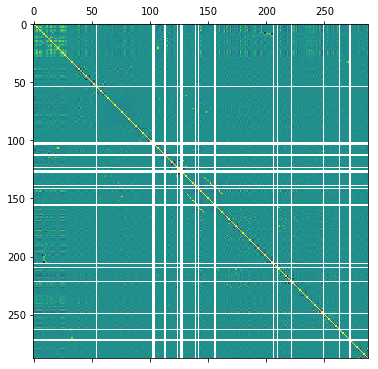

In [68]:
plt.matshow(X_test.corr())
plt.show() 

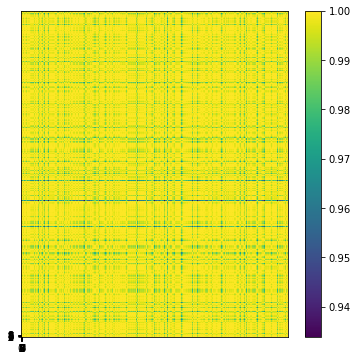

In [69]:

from pylab import pcolor, show, colorbar, xticks, yticks
R = np.corrcoef(X_test)

pcolor(R)
colorbar()
yticks(np.arange(0.5,10.5),range(0,10))
xticks(np.arange(0.5,10.5),range(0,10))
show()

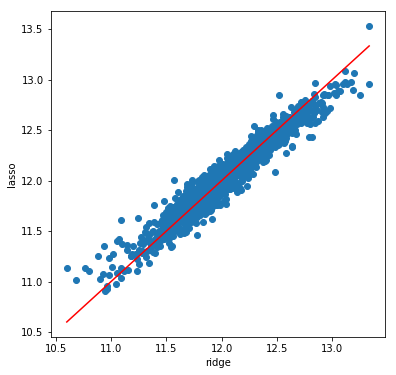

In [70]:
plt.scatter(ridge_preds, lasso_preds)
plt.xlabel('ridge')
plt.ylabel('lasso')
plt.plot( [min(ridge_preds),max(ridge_preds)], [min(ridge_preds),max(ridge_preds)], c="red")
plt.show()

In [71]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

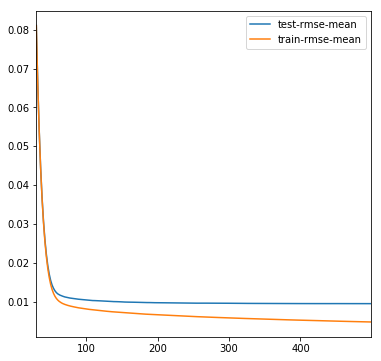

In [72]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

In [73]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [74]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

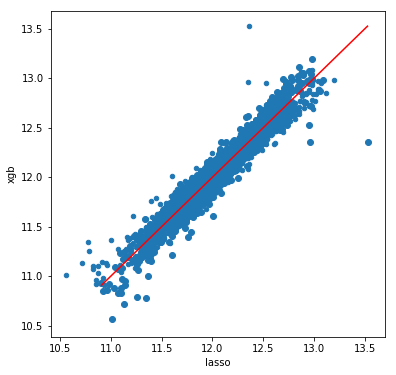

In [75]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

plt.scatter(lasso_preds,xgb_preds)
plt.xlabel('lasso')
plt.ylabel('xgb')
plt.plot( [min(lasso_preds),max(lasso_preds)], [min(lasso_preds),max(lasso_preds)], c="red")
plt.show()